In [1]:
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt
from scipy.io import loadmat
#import cv2
from scipy import ndimage
from scipy import signal
from scipy.ndimage import gaussian_filter
from keras import regularizers
import cv2

Using TensorFlow backend.


In [2]:
from keras.layers import Conv2D, BatchNormalization, Activation , MaxPooling2D, UpSampling2D 
from keras.models import Model, Input
from keras.optimizers import Adam
from keras import initializers
from keras import optimizers
import keras.backend as K
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint

In [3]:
orig = np.load('gray_scale.npy')
orig_resized = np.zeros([orig.shape[0],128,128])

In [4]:
for i in range(orig.shape[0]):
    orig_resized[i] = cv2.resize(orig[i],(128,128))

In [5]:
orig_resized = orig_resized.astype('uint8')
orig_resized.dtype

dtype('uint8')

In [6]:
kernel = loadmat('kernel1.mat')
kernel = kernel['A']

In [7]:
conv = np.zeros_like(orig_resized)
for i in range(orig_resized.shape[0]):
    #conv[i] = signal.fftconvolve(orig_resized[i],kernel,mode = 'same')
    conv[i] = gaussian_filter(orig_resized[i],sigma=3)

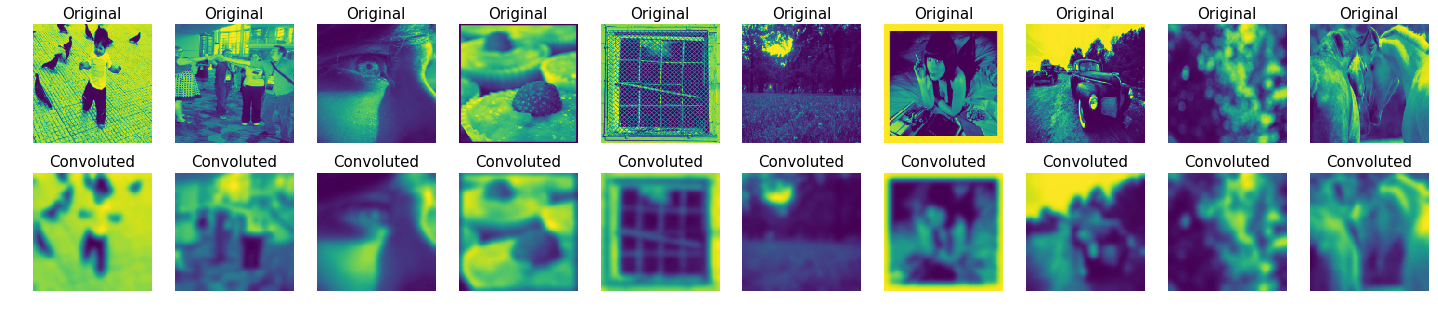

In [8]:
f, ax = plt.subplots(2,10,figsize=(25,5))
for i in range(10):
    ax[0,i].imshow((orig_resized[i+48,:,:]));  ax[0,i].axis('Off'); ax[0,i].set_title('Original', size=15)
    ax[1,i].imshow((conv[i+48,:,:]));  ax[1,i].axis('Off'); ax[1,i].set_title('Convoluted', size=15)
plt.show()

In [9]:
print(orig_resized.dtype,conv.dtype)

uint8 uint8


In [10]:
num_validation = int(orig.shape[0]/25)
num_training = orig.shape[0] - num_validation

conv = conv.astype('float16')
orig_resized = orig_resized.astype('float16')

X_train, Y_train = conv[:num_training], orig_resized[:num_training]
X_val, Y_val = conv[num_training:], orig_resized[num_training:]

print('Xtrain shape: ',X_train.shape)
print('Ytrain shape: ',Y_train.shape)
print('Xval shape: ',X_val.shape)
print('Yval shape: ',Y_val.shape)



Xtrain shape:  (24000, 128, 128)
Ytrain shape:  (24000, 128, 128)
Xval shape:  (1000, 128, 128)
Yval shape:  (1000, 128, 128)


In [11]:
X_train = X_train / 255.0
Y_train = Y_train / 255.0
X_val = X_val / 255.0
Y_val = Y_val / 255.0

In [12]:
X_train = X_train.reshape((-1,128,128,1))
Y_train = Y_train.reshape((-1,128,128,1))
X_val = X_val.reshape((-1,128,128,1))
Y_val = Y_val.reshape((-1,128,128,1))

In [13]:
import tensorflow as tf
tf.reset_default_graph()

In [ ]:
input_img = Input(shape=(128, 128, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same',kernel_initializer=initializers.RandomNormal(stddev = 2/(3*3*1)),
            kernel_regularizer=regularizers.l2(0.001))(input_img)
x = MaxPooling2D((2, 2), padding='valid')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same',kernel_initializer=initializers.RandomNormal(stddev = 2/(3*3*16)),
           kernel_regularizer=regularizers.l2(0.001))(x)
encoded = MaxPooling2D((2, 2), padding='valid')(x)
#x = Conv2D(16, (3, 3), activation='relu', padding='same',kernel_initializer=initializers.RandomNormal(stddev = 2/(3*3*16)),
#           kernel_regularizer=regularizers.l2(0.001))(x)
#encoded = MaxPooling2D((2, 2), padding='valid')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(16, (3, 3), activation='relu', padding='same',kernel_initializer=initializers.RandomNormal(stddev = 2/(3*3*16)),
           kernel_regularizer=regularizers.l2(0.001))(encoded)
#x = Conv2D(16, (3, 3), activation='relu', padding='same',kernel_initializer=initializers.RandomNormal(stddev = 2/(3*3*16)),
#           kernel_regularizer=regularizers.l2(0.001))(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same',kernel_initializer=initializers.RandomNormal(stddev = 2/(3*3*16)),
           kernel_regularizer=regularizers.l2(0.001))(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',kernel_initializer=initializers.RandomNormal(stddev = 2/(3*3*16)),
                 kernel_regularizer=regularizers.l2(0.001))(x)

autoencoder = Model(input_img, decoded)
adam = optimizers.Adam(lr=0.001)
autoencoder.compile(optimizer=adam, loss='mean_squared_error')

In [ ]:
autoencoder.summary()

In [ ]:
tbCallBack = keras.callbacks.TensorBoard(log_dir='./logs/Graph_gaussian_l2reg0.01_mse_randominitkernel_7625param', 
                                         histogram_freq=0, write_graph=True, write_images=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=10, min_lr=0.0001)
model_check = ModelCheckpoint('./models/Graph_gaussian_l2reg0.01_mse_randominitkernel_7625param/weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                              monitor='val_loss', verbose=0, save_best_only=False, 
                                save_weights_only=False, mode='auto', period=1)

In [ ]:
autoencoder.fit(X_train, Y_train,
                epochs= 30,
                batch_size=64,
                shuffle=True,
                validation_data=(X_val, Y_val),
                callbacks=[tbCallBack,reduce_lr,model_check])

In [14]:
input_img = Input(shape=(128, 128, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (7, 7), activation='relu', padding='same',kernel_initializer=initializers.RandomNormal(stddev = 2/(3*3*1)),
            kernel_regularizer=regularizers.l2(0.001))(input_img)
x = keras.layers.BatchNormalization()(x)
x = Conv2D(16, (5, 5), activation='relu', padding='same',kernel_initializer=initializers.RandomNormal(stddev = 2/(3*3*16)),
           kernel_regularizer=regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same',kernel_initializer=initializers.RandomNormal(stddev = 2/(3*3*16)),
           kernel_regularizer=regularizers.l2(0.001))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same',kernel_initializer=initializers.RandomNormal(stddev = 2/(3*3*16)),
           kernel_regularizer=regularizers.l2(0.001))(x)
out = Conv2D(1, (3, 3), activation='sigmoid', padding='same',kernel_initializer=initializers.RandomNormal(stddev = 2/(3*3*16)),
                 kernel_regularizer=regularizers.l2(0.001))(x)

autoencoder = Model(input_img, out)
adam = optimizers.Adam(lr=0.0005)
autoencoder.compile(optimizer=adam, loss='mean_squared_error')

autoencoder.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      800       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 16)      6416      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 16)      2320      
__________

In [15]:
tbCallBack = keras.callbacks.TensorBoard(log_dir='./logs/mse_randominitkernel_model2_batchnorm_lr0.0005', 
                                         histogram_freq=0, write_graph=True, write_images=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=10, min_lr=0.0001)
model_check = ModelCheckpoint('./models/mse_randominitkernel_model2_batchnorm_lr0.0005/weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                              monitor='val_loss', verbose=0, save_best_only=False, 
                                save_weights_only=False, mode='auto', period=1)

autoencoder.fit(X_train, Y_train,
                epochs= 50,
                batch_size=64,
                shuffle=True,
                validation_data=(X_val, Y_val),
                callbacks=[tbCallBack,reduce_lr,model_check])

Train on 24000 samples, validate on 1000 samples
Epoch 1/50
24000/24000 [==============================] - 65s 3ms/step - loss: 0.0355 - val_loss: 0.0268
Epoch 2/50
24000/24000 [==============================] - 63s 3ms/step - loss: 0.0155 - val_loss: 0.0272
Epoch 3/50
24000/24000 [==============================] - 63s 3ms/step - loss: 0.0106 - val_loss: 0.0199
Epoch 4/50
24000/24000 [==============================] - 63s 3ms/step - loss: 0.0088 - val_loss: 0.0107
Epoch 5/50
24000/24000 [==============================] - 63s 3ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 6/50
24000/24000 [==============================] - 63s 3ms/step - loss: 0.0076 - val_loss: 0.0090
Epoch 7/50
24000/24000 [==============================] - 63s 3ms/step - loss: 0.0072 - val_loss: 0.0079
Epoch 8/50
24000/24000 [==============================] - 62s 3ms/step - loss: 0.0070 - val_loss: 0.0077
Epoch 9/50
24000/24000 [==============================] - 62s 3ms/step - loss: 0.0069 - val_loss: 0.0095
Epoch 

KeyboardInterrupt: 

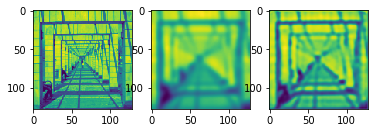

In [16]:
pred = autoencoder.predict(X_val)
plt.subplot(1,3,1)
plt.imshow((Y_val[90,:,:,0]*255.0).astype('uint8'))
plt.subplot(1,3,2)
plt.imshow((X_val[90,:,:,0]*255.0).astype('uint8'))
plt.subplot(1,3,3)
plt.imshow((pred[90,:,:,0]*255.0).astype('uint8'))

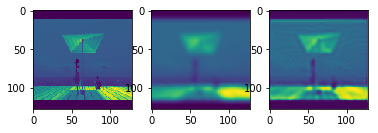

In [17]:
pred_train = autoencoder.predict(X_train[0:100])
plt.subplot(1,3,1)
plt.imshow((Y_train[91,:,:,0]*255.0).astype('uint8'))
plt.subplot(1,3,2)
plt.imshow((X_train[91,:,:,0]*255.0).astype('uint8'))
plt.subplot(1,3,3)
plt.imshow((pred_train[91,:,:,0]*255.0).astype('uint8'))

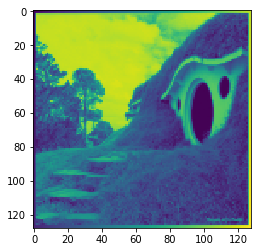

In [21]:
plt.imshow((Y_val[10,:,:,0]*255.0).astype('uint8'))